In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
set_session(tf.Session(config=config))

In [ ]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [1]:
import os
import skimage.io
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!pwd
#os.chdir('project')
!pwd

/home/shared/project/MaskTrack_RCNN/project
/home/shared/project/MaskTrack_RCNN/project


In [3]:
os.chdir('../') # OPTIMIZATION EDIT: import most recent mrcnn code from local code

# Import Mask RCNN
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import utils

os.chdir('project')  # OPTIMIZATION EDIT: revert to current directory

Using TensorFlow backend.


In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print('Project Directory: {}'.format(ROOT_DIR))

# Root directory of the dataset
DATA_DIR = os.path.join(ROOT_DIR, "dataset/wad")
print('Data Directory: {}'.format(DATA_DIR))

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
print('Logs and Model Directory: {}'.format(LOGS_DIR))

# Local path to trained coco weights file
COCO_MODEL_PATH = os.path.join(LOGS_DIR, 'mask_rcnn_coco.h5')
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Project Directory: /home/shared/project/MaskTrack_RCNN
Data Directory: /home/shared/project/MaskTrack_RCNN/dataset/wad
Logs and Model Directory: /home/shared/project/MaskTrack_RCNN/logs


In [5]:
!ls $DATA_DIR/train_color | wc -l
!ls $DATA_DIR/val_color | wc -l

234
52


## Configuration

In [6]:
import wad_data # --> made change here
#import wad_data_testing_optimization as wad_data

cfg = wad_data.WADConfig()
cfg.IMAGES_PER_GPU = 3 # depends on GPU RAM
cfg.BATCH_SIZE = 3
cfg.STEPS_PER_EPOCH = 78 # 390 # 78 # Total number of training samples / batch size ==> 234 / 6
# note: consider augmentations when calculating steps per epoch
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                48
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_I

## Dataset

load_mask has been tested. green light .. green light

In [7]:
# Don't rerun this block during consecutive tests

dataset_train = wad_data.WADDataset()
dataset_val = dataset_train.load_data(DATA_DIR, "train", val_size=0.2)

dataset_train.prepare()
dataset_val.prepare()

dataset_val.save_data_to_file(os.path.join(LOGS_DIR, "last_run_validation.pkl"))

/home/shared/project/MaskTrack_RCNN/dataset/wad/train


In [ ]:
# https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [ ]:
### MODIFICATION 1: AUGMENTATIONS

# !pip install git+https://github.com/aleju/imgaug

import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

"""
Augmentations to use:

Geometric:
- horizontal flip
- crop
- zoom

Color:
- contrast

"""

# NOT only preforms one augmentation at a time
# preforms these augmentations in order
seq = iaa.Sequential([
    
    # no change - still want to feed original image through network sometimes
    # iaa.Noop(),
    
    # simulate various angles
    iaa.Fliplr(0.5), # increases dataset size by a factor of 2
    
    # simulate different sizes and locations
    iaa.CropAndPad(percent=(-0.25, 0.25)),
    
    # simulate brightness changes
    iaa.ContrastNormalization((0.5, 1.5)), # add per channel?
    
    # simulate occlusions - TEST THIS VARIABLE - make bigger occlusions
    # iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),
    
    # horizontal shear - trapezoidal shear
    
    # simulate visibility
    iaa.GaussianBlur(sigma=(0.0, 3.0))
    
])

In [ ]:
# Visualize augmentations

# Test on a random image
import random 

class InferenceConfig(wad_data.WADConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
    dataset_val, inference_config,  image_id, use_mini_mask=False)

# plt.imshow(original_image)

copies_of_image = [original_image for i in range(0, 10)] # generate 10 copies of the image

augmentations = [original_image] + seq.augment_images(copies_of_image[1:]) # leave out first one

show_images(augmentations, cols=2)

## Training

In [8]:
%%time

# Load Model

STARTING_WEIGHTS = os.path.join(LOGS_DIR, 'mask_rcnn_coco.h5')

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=cfg, model_dir=LOGS_DIR)

model.load_weights(STARTING_WEIGHTS, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

CURRENTLY EDITTING FOR OPTIMIZATION, DO NOT USE IN PRODUCTION USE
CPU times: user 9.03 s, sys: 1.51 s, total: 10.5 s
Wall time: 10.2 s


In [ ]:
# Learning Rate Finder

# !pip install git+https://github.com/surmenok/keras_lr_finder -> not a callback, want a callback

# !wget https://gist.githubusercontent.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02/raw/3b780822389cb4d96c50e83b59b8a506120fb044/lr_finder.py

In [9]:
import time

start_time = time.time()

model.train(dataset_train, dataset_val, 
            learning_rate=cfg.LEARNING_RATE, 
            epochs=1, 
            layers='heads') #,
            #augmentation=seq)
    
print('----- TRAINED HEADS -----')
training_time = time.time() - start_time
print('TRAINING TIME: ' + str(training_time))

"""

start_time = time.time()

model.train(dataset_train, dataset_val, 
            learning_rate=cfg.LEARNING_RATE, 
            epochs=2, # note: epoch number PICKS UP FROM LAST TRAINING for this instance of the model!
            layers='all',
            augmentation=seq)

print('----- TRAINED ALL -----')
training_time = time.time() - start_time
print('TRAINING TIME: ' + str(training_time))

"""


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/shared/project/MaskTrack_RCNN/logs/wad20180629T2041/mask_rcnn_wad_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/shared/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
77/78 [============================>.] - ETA: 1s - loss: 1.8279 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.8299 - mrcnn_class_loss: 0.2978 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.2784

/home/shared/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


78/78 [==============================] - 341s 4s/step - loss: 1.8397 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.8491 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.4079 - mrcnn_mask_loss: 0.2764 - val_loss: 1.4510 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 1.0006 - val_mrcnn_class_loss: 0.0355 - val_mrcnn_bbox_loss: 0.2155 - val_mrcnn_mask_loss: 0.1903
----- TRAINED HEADS -----
TRAINING TIME: 345.9803948402405


"\n\nstart_time = time.time()\n\nmodel.train(dataset_train, dataset_val, \n            learning_rate=cfg.LEARNING_RATE, \n            epochs=2, # note: epoch number PICKS UP FROM LAST TRAINING for this instance of the model!\n            layers='all',\n            augmentation=seq)\n\nprint('----- TRAINED ALL -----')\ntraining_time = time.time() - start_time\nprint('TRAINING TIME: ' + str(training_time))\n\n"

In [10]:
# ??model.train()
print(dir(model))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_anchor_cache', 'ancestor', 'anchors', 'build', 'checkpoint_path', 'compile', 'config', 'detect', 'detect_molded', 'epoch', 'find_last', 'find_trainable_layer', 'get_anchors', 'get_imagenet_weights', 'get_trainable_layers', 'keras_model', 'load_weights', 'log_dir', 'lr_finder', 'mode', 'model_dir', 'mold_inputs', 'run_graph', 'set_log_dir', 'set_trainable', 'train', 'unmold_detections']


In [11]:
keras_model = model.keras_model
lr_finder = model.lr_finder

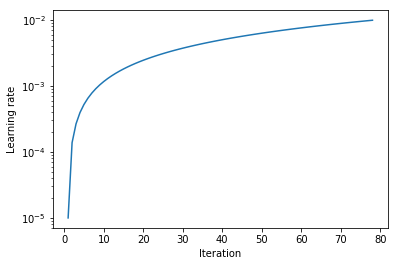

In [13]:
lr_finder.plot_lr()

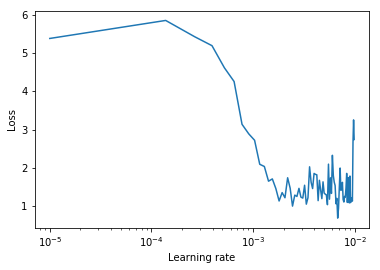

In [14]:
lr_finder.plot_loss()

In [ ]:
# Get final validation accuracy

# Why is it calculating 50 validation steps: that might not be the validation dataset size

from mrcnn.model import data_generator
import multiprocessing

val_generator = data_generator(dataset_val, cfg, shuffle=True, batch_size=cfg.BATCH_SIZE)
keras_model = model.keras_model

val_metrics = keras_model.evaluate_generator(
    val_generator, 
    steps = cfg.VALIDATION_STEPS,
    workers = multiprocessing.cpu_count(),
    use_multiprocessing = True,
    verbose = 1
)

metric_labels = ['val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss', 
                 'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss']

fmt = '{:<25}{}'

for label, value in zip(metric_labels, val_metrics):
    print(fmt.format(label, value))

In [ ]:
# Inference

class InferenceConfig(wad_data.WADConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model_inference = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_inference_path = os.path.join(LOGS_DIR, 'wad20180628T1826/mask_rcnn_wad_0002.h5')

# Load trained weights
print("Loading weights from ", model_inference_path)
model.load_weights(model_inference_path, by_name=True)

In [ ]:
import random
from mrcnn import visualize

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))